In [1]:
import numpy as np
import keras
import utils

import matplotlib.pyplot as plt

print("Keras : {}".format(keras.__version__))
%matplotlib inline 

Using TensorFlow backend.


Keras : 2.0.6


## Caisse à outils

```python
#charger le dataset mnist
utils.load_mnist

#one-hot encoding des labels
keras.utils.np_utils.to_categorical

#créer un modèle avec Keras
keras.models.Sequential

#ajouter des couches dedans 
keras.layers.InputLayer
keras.layers.Dense
keras.layers.Activation

#entrainer le modele par descente du gradient
keras.optimizers.SGD
```

## Importer les données

- télécharge et décompresse le dataset MNIST
- le dataset est déjà découpé en 'train+test'

In [3]:
(x_train, y_train), (x_test, y_test) = utils.load_mnist(path="mnist/")

## Pré-traitement des images

- conversion en `float` (réel)
- obtenir des valeurs entre `[0.0 , 1.0]` 
    - division par `255.`

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [5]:
x_train = x_train/255.
x_test = x_test/255.

In [7]:
# x_train.shape : [60000, 28, 28]
# ici conversion de chaque image en vecteur de taille 784=28*28
# opération dite de `flatten()`
x_train = x_train.reshape([-1, 28*28])
x_test = x_test.reshape([-1, 28*28])

In [8]:
print(x_train.shape)
print(x_test.dtype)

(60000, 784)
float32


## "One-hot encoding" : préparation des labels

Il faut convertir les labels en vecteurs, par 'one-hot encoding'.

On sait qu'il y a 10 classes. 

Donc un exemple labelisé par `y_train[i]=5` sera remplacé par `y_train_enc[i]=[0,0,0,0,0,1,0,0,0,0]`

Keras dispose d'une fonction pour faire ça rapidement. Elle détecte même le nombre de classe (mais on peut quand même indiqué cette information nous-même).

In [9]:
from keras.utils.np_utils import to_categorical
y_train_enc = to_categorical(y_train, num_classes=10)
y_test_enc = to_categorical(y_test, num_classes=10)

In [11]:
print("label : {}".format(y_train[0]))
print("label encodé : {}".format(y_train_enc[0]))

label : 5
label encodé : [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


## Construction du réseau de neurones  

On peut maintenant construire notre premier réseau de neurones. 

Il s'agit du réseau le plus simple : 
- 784 neurones en entrées (les pixels)
- 10 neurones en sortie (le nombre de classes)
- pas de couches cachées entre !
- on termine par une fonction d'activation 'softmax'

L'opération pour passes entre ces deux couches de neurones, est un produit matriciel et l'addition d'un vecteur de biais. (cf. slides). Le nombre de paramètres à entraîner est donc : 

- une matrice de taille [784, 10] --> 7840 paramètres 
- un vecteur de biais de taille [10,] --> 10 paramètres 

Au total : 7850 paramètres ! 

In [14]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Activation

In [17]:
# on crée un modèle vide
model = Sequential()

#on ajoute une première couche qui spécifie la taille des données
model.add(InputLayer(input_shape=(784,)))

# on ajoute la couche de neurones de sorties
model.add(Dense(10))

# puis la fonction d'activation 'softmax'
model.add(Activation("softmax"))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


**Note** : On retrouve bien les 7850 paramètres prévus !

## Apprentissage du réseau de neurones

Maintenant on doit entrîner le modèle, par descente du gradient. 

Dans un premier temps il faut : 
- spécifier l'algorithme d'optimisation (SGD : descente du gradient stochastique)
- spécifier une fonction d'erreur 
    - dans le cas de la classification d'images -> entropie croisée
    - c'est cette valeur qui va être minimisée
- ajouter si on veut des métriques (optionel)
    - juste pour ajouter une information 
    - dans le cas de la classification, on peut ajouter la précision (nb de bonnes prédictions/nb de prédictions)

(voir dans la documentation pour plus de métriques)

In [27]:
# on crée un optimizer de type SGD, et on spécifie le pas d'apprentissage 
# qui sera constant pendant tout l'entraînement

from keras.optimizers import SGD
sgd = SGD(lr=0.001)

In [28]:
# on utilise la méthode .compile() du modèle crée précédemment.
# on ajoute l'algo d'optimisation, le nom de la fonction d'erreur à utiliser
# et les métriques à utiliser 

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Lancer l'entraînement

On peut enfin lancer l'entraînement !

Pour ça, on utilise la méthode `.fit()` du modèle. 

On y ajoute : 
- les données d'entraînements
- les labels encodés
- la taille de batch
- le nombre d'epochs (nb iteration = nb_epoch * (nb exemple // batch_size))
- on peut découper le dataset d'entraînement en 80% + 20%
     - 80% pour l'entraînement
     - 20% pour évaluer le modèle à la fin de chaque époque 
- `shuffle=True` oblige Keras à mélanger les données d'entraînement à la fin de chaque epoch
    - permet d'avoir des batchs différents à chaque epoch.

Cette fonction retourne un objet `history`.Il contient des informations sur l'entraînement. 

Notamment les valeurs de la fonction de d'erreur et des métriques. 

In [29]:
history = model.fit(x_train, y_train_enc,
              batch_size=32, epochs=50,
              verbose=2,
              validation_split=0.2,
              shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
1s - loss: 1.7774 - acc: 0.5217 - val_loss: 1.3484 - val_acc: 0.7491
Epoch 2/50
1s - loss: 1.1656 - acc: 0.7811 - val_loss: 0.9826 - val_acc: 0.8277
Epoch 3/50
1s - loss: 0.9215 - acc: 0.8212 - val_loss: 0.8118 - val_acc: 0.8478
Epoch 4/50
1s - loss: 0.7946 - acc: 0.8370 - val_loss: 0.7136 - val_acc: 0.8558
Epoch 5/50
1s - loss: 0.7164 - acc: 0.8461 - val_loss: 0.6496 - val_acc: 0.8627
Epoch 6/50
1s - loss: 0.6627 - acc: 0.8516 - val_loss: 0.6046 - val_acc: 0.8667
Epoch 7/50
1s - loss: 0.6235 - acc: 0.8559 - val_loss: 0.5703 - val_acc: 0.8712
Epoch 8/50
1s - loss: 0.5933 - acc: 0.8598 - val_loss: 0.5440 - val_acc: 0.8740
Epoch 9/50
1s - loss: 0.5691 - acc: 0.8630 - val_loss: 0.5228 - val_acc: 0.8758
Epoch 10/50
1s - loss: 0.5493 - acc: 0.8653 - val_loss: 0.5051 - val_acc: 0.8791
Epoch 11/50
1s - loss: 0.5326 - acc: 0.8677 - val_loss: 0.4903 - val_acc: 0.8802
Epoch 12/50
1s - loss: 0.5184 - acc: 0.8702 - val_loss: 0.4778 - val

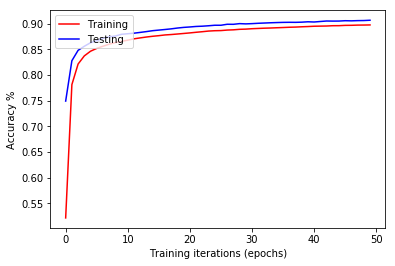

In [30]:
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'b')
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations (epochs)')
plt.legend(['Training','Testing'], loc='upper left')
plt.show()

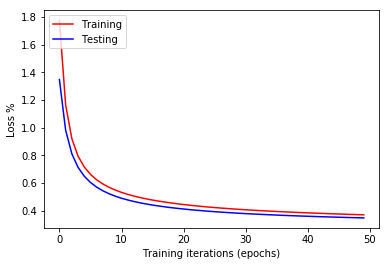

In [31]:
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.ylabel('Loss %')
plt.xlabel('Training iterations (epochs)')
plt.legend(['Training','Testing'], loc='upper left')
plt.show()

## Evaluer le modèle sur le données de test 

Le modèle est entraîné. 

On peut maintenant l'évaluer pour de bon avec le dataset de test.

Pour ça on utilise la méthode `.evaluate()` du modèle : 
- on donne les données (images sous la forme de vecteurs)
    - **les données de test doivent avoir subis les mêmes opérations que les données d'entraînement**
- on donne les bonnes réponses (les labels encodés)

Cette méthodes retourne dans un tableau : 
- la valeur moyenne de la fonction d'erreur 
- la valeur moyenne de chacune des métriques choisies plus haut

Dans notre cas: `[categorical_entropy, accuracy]`

In [33]:
res = model.evaluate(x_test, y_test_enc)
print("\n[loss, accuracy] : {}".format(res))

 9952/10000 [============================>.] - ETA: 0s
[loss, accuracy] : [0.34768927928209303, 0.90469999999999995]


### Faire des prédictions

On peut aussi obtenir les prédictions : 
- pour chaque exemple, on a la classe la plus probable 

In [34]:
pred = model.predict_classes(x_test)

 7136/10000 [====================>.........] - ETA: 0s

In [35]:
print(pred.shape)
print(pred[0])

(10000,)
7


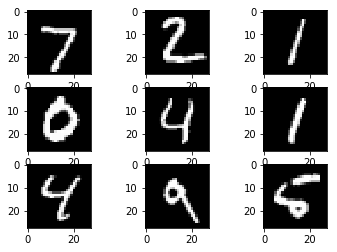

[7 2 1 0 4 1 4 9 6]
[7 2 1 0 4 1 4 9 5]


In [36]:
for i in range(9):
    plt.subplot(331+i)
    #Les images sont sous forme de vecteurs, de taille 784=28x28
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.show()
print(pred[:9])
print(y_test[:9])

### Obtenir les probabilités d'appatenance à chacune des classes

On peut aussi obtenit le vecteur d'appartenance à chacune des classes. 

Cela permet d'observer le niveau de confidence d'une réponse. 

In [38]:
probs = model.predict(x_test)
print(probs.shape)
print(probs[8])
print(y_test_enc[8])

(10000, 10)
[  3.44166420e-02   9.80403973e-04   1.18018992e-01   1.21326048e-04
   6.27961755e-02   2.27145310e-02   7.31981158e-01   3.36120138e-04
   2.13943664e-02   7.24023394e-03]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


Ici, 
- le modèle est ceratin à 73,2% que l'image `8` est un 6. 
- 11.8% que c'est un `2`
- 2.3% que c'est un `5`

Alors que la bonne réponse est `5`

## Sauvegarder et charger des modèles 

Le modèle actuellement en mémoire est entrainé. 

Pour le réutiliser plus tard, il existe plusieurs méthodes de sauvegarde. 


#### Uniquement l'architecture du modèle (pas ses paramètres internes) 

- il faudra alors ré-entraîner le modèle ! 

In [39]:
import json
from pprint import pprint

# Keras convertit sous la forme d'une chaîne de caractères (string) les spécifications du modèle.
json_string = model.to_json()

# cette 'string' est au format json
# on peut la sauvegarder dans un fichier. 
with open('models/model_vanilla_NN.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [40]:
# voici le contenu de la string
print(json_string)

{"backend": "tensorflow", "class_name": "Sequential", "keras_version": "2.0.6", "config": [{"class_name": "Dense", "config": {"activity_regularizer": null, "bias_regularizer": null, "name": "dense_3", "kernel_initializer": {"class_name": "VarianceScaling", "config": {"mode": "fan_avg", "distribution": "uniform", "seed": null, "scale": 1.0}}, "use_bias": true, "batch_input_shape": [null, 784], "units": 10, "kernel_regularizer": null, "trainable": true, "dtype": "float32", "bias_initializer": {"class_name": "Zeros", "config": {}}, "activation": "softmax", "bias_constraint": null, "kernel_constraint": null}}]}


In [41]:
# il existe une fonction pour recréer le modèle à partir de cette chaine de caractères.
from keras.models import model_from_json
model_json = model_from_json(json_string)

# ici model_json est un modèle similaire à `model`
# même architecture/topologie 
# mais il n'est pas entraîné ! 

#### Sauvegarder un modèle et ses poids 

On peut aussi sauvegarder tout le modèle {architecture + paramètres entrainés} dans un seul fichier ! 

Il s'agit d'un fichier `HDF5` très utile pour stocker facilement des tableaux et valeurs numériques.

In [42]:
model.save("models/model_vanilla_NN.h5")

In [43]:
# il existe aussi une fonction pour créer un modèle à partir de ce fichier. 
from keras.models import load_model
model_h5 = load_model("models/model_vanilla_NN.h5")

# ici model_h5 est le même que model : 
# - même architecture 
# - même paramètres (entraînés)

# donc même performances :

In [44]:
model_h5.evaluate(x_test, y_test_enc)

 8288/10000 [=======================>......] - ETA: 0s

[0.34768927928209303, 0.90469999999999995]